# Example for analysis of NanoAOD samples

In this example we don't need any pre-processing of NanoAOD samples and can still use several tools of the tW_scattering repository.

- Get the proper normalization for samples
- Categorize different samples into process categories
- Use coffea processors for the map-reduce step
- Make "nice" histograms


In [1]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.nano_analysis import nano_analysis
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

In [3]:
from klepto.archives import dir_archive
from processor.std_acumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

overwrite = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'nano_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples()

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['DY', 'TTZ', 'top'], samples, redirector=redirector_ucsd, small=True)

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
     "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        nano_analysis(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

I'm running now


Preprocessing:   0%|          | 0/4 [00:00<?, ?file/s]

Processing:   0%|          | 0/17 [00:00<?, ?chunk/s]

In [4]:
output['totalEvents']['all']/1e6

3.786047

Full fileset is 180M events, and that's basically just DY and ttbar.

In [25]:
# import the plotting libararies: matplotlib and mplhep

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import numpy as np


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', 20, 0, 400)
pt_bins2       = hist.Bin('pt', r'$p_{T}\ (GeV)$', np.array([15, 40, 60, 80, 100, 200, 300]))
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins       = hist.Bin('eta', r'$\eta $', 10, -2.5, 2.5)
eta_bins2      = hist.Bin('eta', r'$\eta $', np.array([-2.5, -1.5, -1, 0, 1, 1.5, 2.5]))
eta_bins3      = hist.Bin('eta', r'$\eta $', np.array([0,0.79, 1.479, 2.5]))
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)


# define nicer labels and colors

my_labels = {
    nano_mapping['TTW'][0]: 'ttW',
    nano_mapping['TTZ'][0]: 'ttZ',
    nano_mapping['DY'][0]: 'DY',
    nano_mapping['top'][0]: 't/tt+jets',
}

my_colors = {
    nano_mapping['TTW'][0]: '#8AC926',
    nano_mapping['TTZ'][0]: '#FFCA3A',
    nano_mapping['DY'][0]: '#6A4C93',
    nano_mapping['top'][0]: '#1982C4',
}



# 1D Histograms

Data: 0 MC: 1242397.4


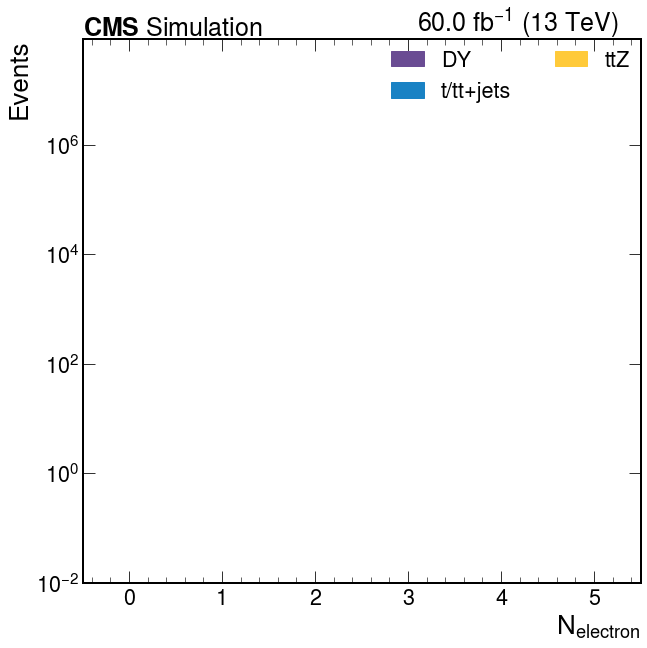

In [18]:
# take the N_ele histogram out of the output, apply the x-secs from samples to the samples in fileset
# then merge the histograms into the categories defined in nano_mapping


my_hist = scale_and_merge(output['N_ele'], samples, fileset, nano_mapping)

# Now make a nice plot of the electron multiplicity.
# You can have a look at all the "magic" (and hard coded monstrosities) that happens in makePlot
# in plots/helpers.py

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

In [19]:
output['N_ele']


<Hist (dataset,multiplicity) instance at 0x7f8e3dce9970>

Data: 0 MC: 1242397.4


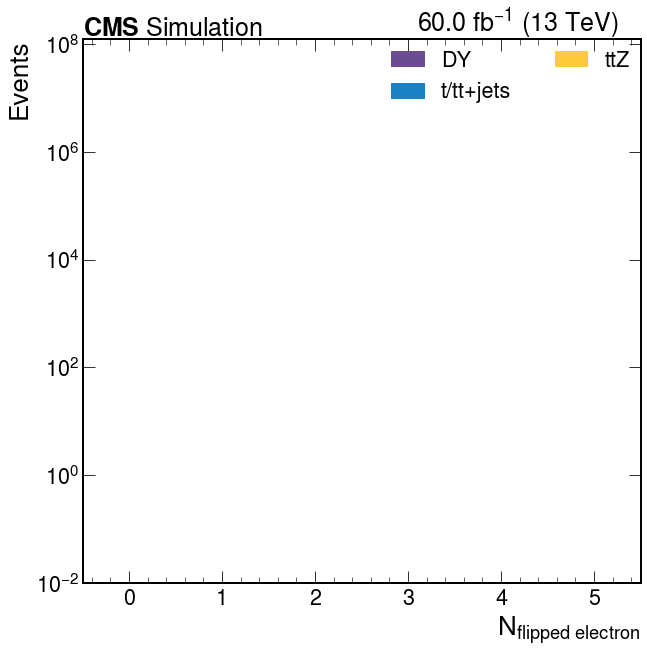

In [10]:
my_hist = scale_and_merge(output['electron_flips'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'multiplicity',
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{flipped\ electron}$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 1242397.4


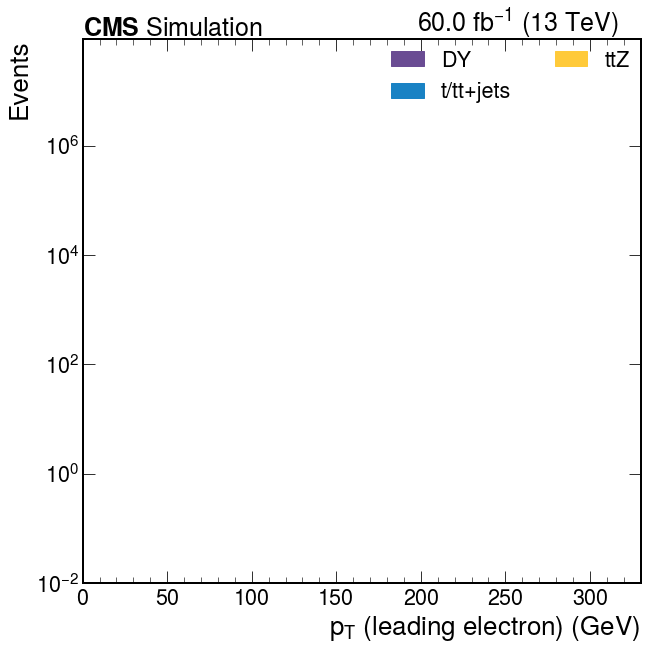

In [11]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (leading\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 549.9


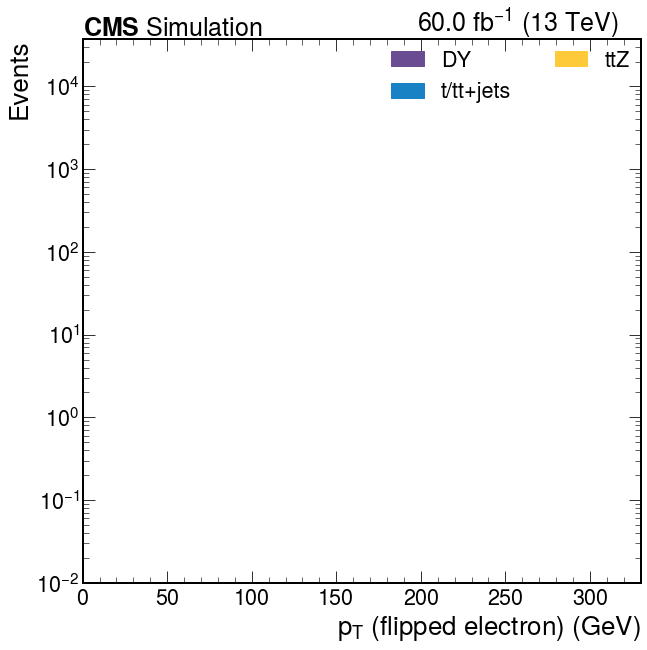

In [12]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'pt',
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}\ (flipped\ electron)\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 1242397.39


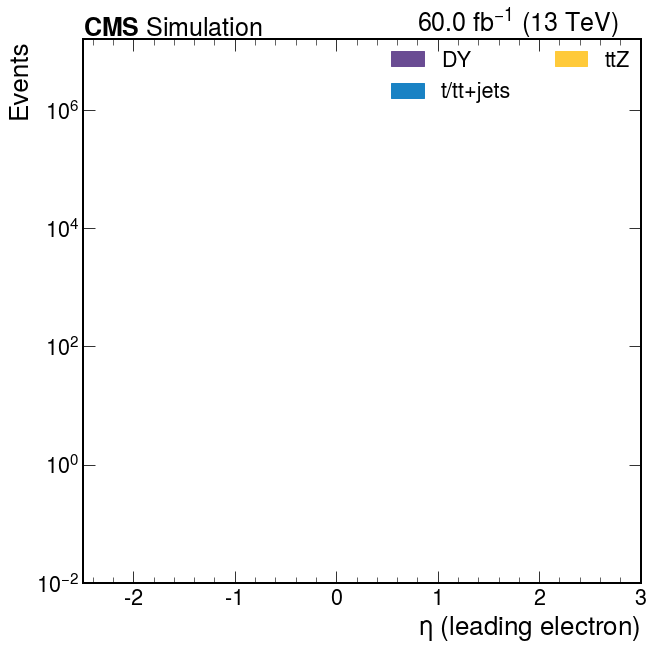

In [13]:
my_hist = scale_and_merge(output['electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (leading\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

Data: 0 MC: 549.9


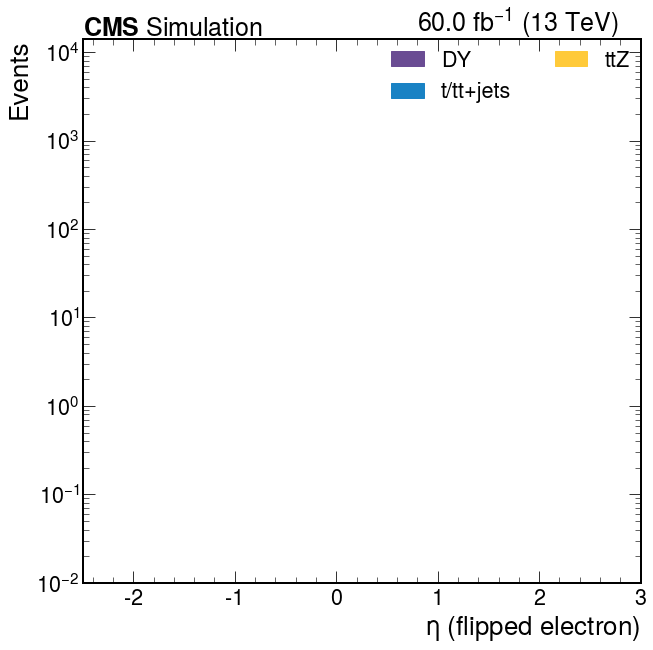

In [14]:
my_hist = scale_and_merge(output['flipped_electron'], samples, fileset, nano_mapping)

makePlot(my_hist, None, 'eta',
         bins=eta_bins, log=True, normalize=False, axis_label=r'$\eta\ (flipped\ electron)$',
         new_colors=my_colors, new_labels=my_labels,
         order=[nano_mapping['TTZ'][0], nano_mapping['top'][0], nano_mapping['DY'][0]],
        )

# 2D Histograms

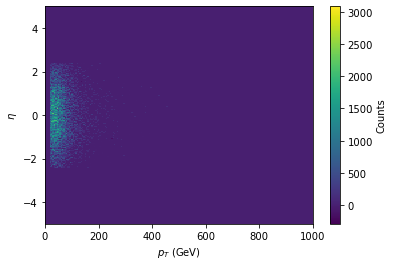

In [5]:
ax = hist.plot2d(
    output['electron'].sum('dataset'),
    xaxis='pt')

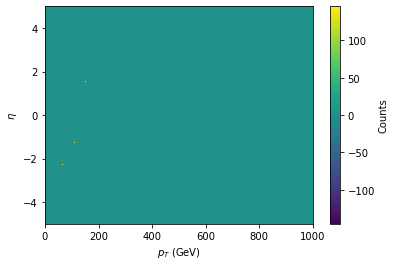

In [6]:
ax = hist.plot2d(
    output['flipped_electron'].sum('dataset'),
    xaxis='pt')

In [20]:
from yahist import Hist1D, Hist2D
import numpy as np

In [21]:
tmp1 = output['flipped_electron'].copy()
tmp1 = tmp1.rebin('eta', eta_bins2)
tmp1 = tmp1.rebin('pt', pt_bins2)


tmp2 = output['electron'].copy()
tmp2 = tmp2.rebin('eta', eta_bins2)
tmp2 = tmp2.rebin('pt', pt_bins2)

h1 = Hist2D.from_bincounts(
    tmp1.sum('dataset').values()[()].T,
    (tmp1.axis('pt').edges(), tmp1.axis('eta').edges()),
)


h2 = Hist2D.from_bincounts(
    tmp2.sum('dataset').values()[()].T,
    (tmp2.axis('pt').edges(), tmp2.axis('eta').edges()),
)

Text(0, 1, '$ratio$')

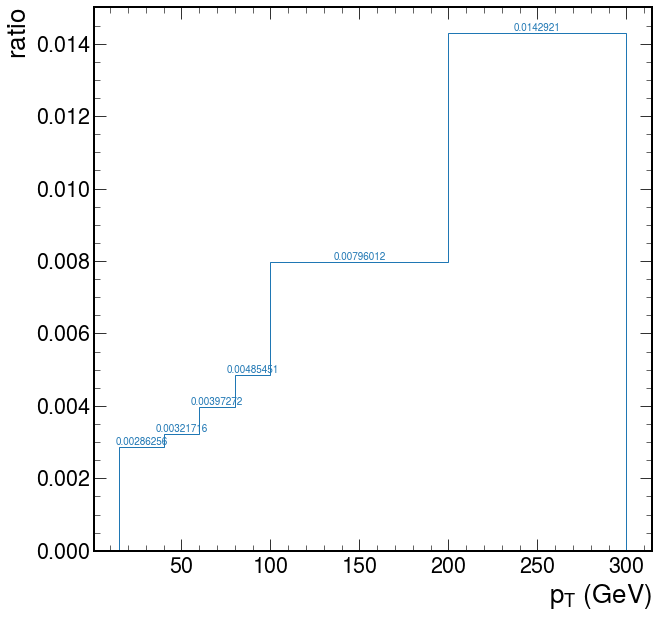

In [22]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h1.divide(h2).projection("x").plot(show_counts=True)
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$ratio$')

Text(0, 1, '$ratio$')

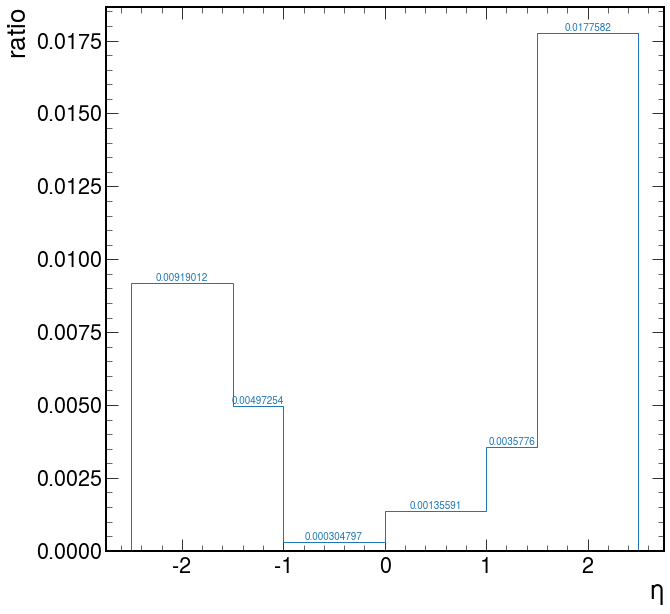

In [23]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h1.divide(h2).projection("y").plot(show_counts=True)
ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$ratio$')

In [26]:
tmp3 = output['flipped_electron'].copy()
tmp3 = tmp3.rebin('eta', eta_bins3)
tmp3 = tmp3.rebin('pt', pt_bins2)


tmp4 = output['electron'].copy()
tmp4 = tmp4.rebin('eta', eta_bins3)
tmp4 = tmp4.rebin('pt', pt_bins2)

h3 = Hist2D.from_bincounts(
    tmp3.sum('dataset').values()[()].T,
    (tmp3.axis('pt').edges(), tmp3.axis('eta').edges()),
)


h4 = Hist2D.from_bincounts(
    tmp4.sum('dataset').values()[()].T,
    (tmp4.axis('pt').edges(), tmp4.axis('eta').edges()),
)

Text(0, 1, '$\\eta$')

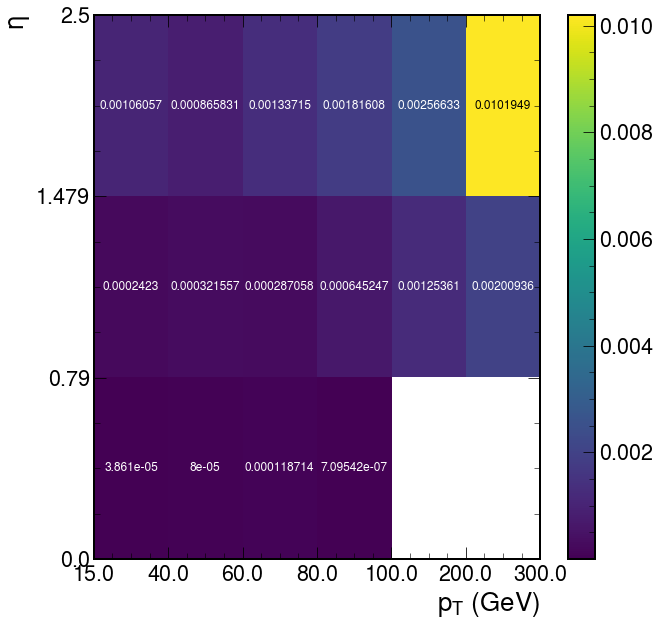

In [27]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h3.divide(h4).plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')

Text(0, 1, '$\\eta$')

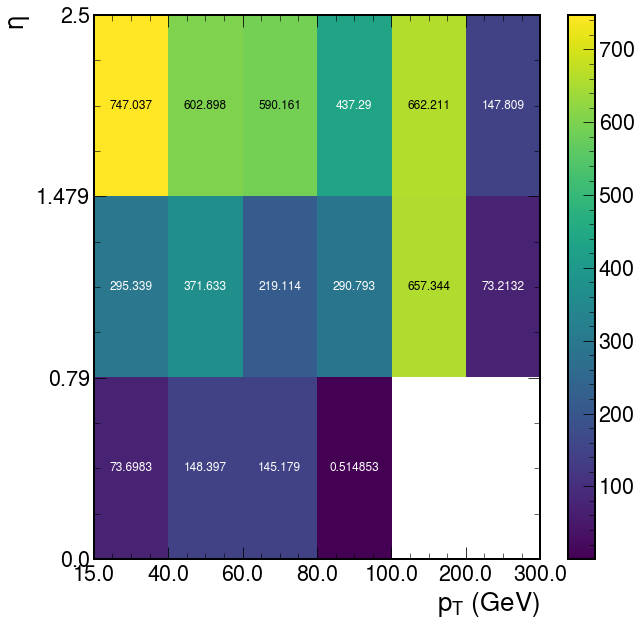

In [28]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h3.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')

Text(0, 1, '$\\eta$')

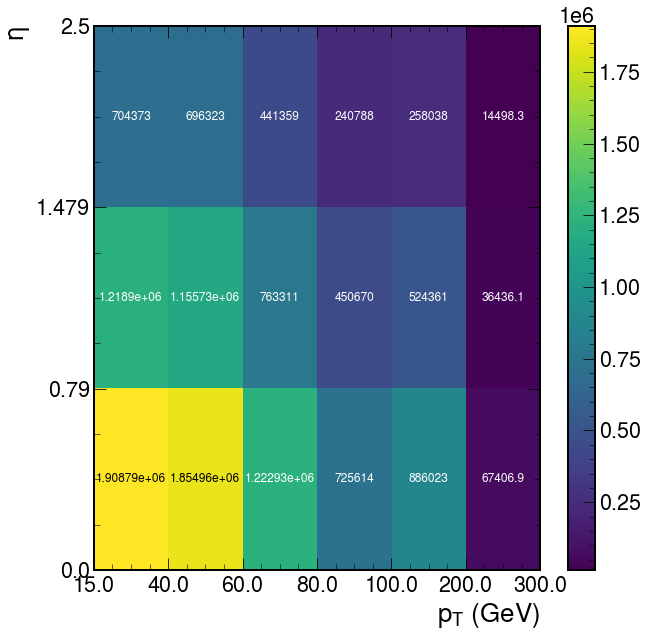

In [29]:
fig, ax  = plt.subplots(1, 1,figsize=(10,10) )
h4.plot(show_counts=True, equidistant='xy')
ax.set_xlabel(r'$p_{T}\ (GeV)$')
ax.set_ylabel(r'$\eta$')

In [30]:
import cloudpickle
import gzip

outname = 'chargeflip'
os.system("mkdir -p histos/")
print('Saving histo in %s...'%("histos/" + outname + ".pkl.gz"))
with gzip.open("histos/" + outname + ".pkl.gz", "wb") as fout:
    cloudpickle.dump(h3.divide(h4), fout)

Saving histo in histos/chargeflip.pkl.gz...
